In [7]:
%matplotlib inline
import numpy as np  
import pandas as pd  
import seaborn as sns  
import qgrid
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)

In [8]:
qgrid.nbinstall(overwrite=True)

# Fuction to generate random data 
 
Create a toy dataset based on a very simple model that we might imagine is a noisy physical process

Model form: 
    
   

$$y \mathtt{\sim} a + bx + cx^2 + e$$

* a: Intercept
* b: Linear coefficient
* c: Quadratic coefficient
* e: Latent error

In [9]:
def generate_data(n=25, a=1, b=1, c=0, latent_error_y=1):  

    ## create linear or quadratic model
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## add latent error noise
    df['y'] += rndst.normal(0,latent_error_y,n)

    return df

# Linear Model

### Generating simple linear model

$$y∼a+bx+cx^{2}+e$$ 
$$a = 5$$
$$b = 2$$
$$e = 15$$

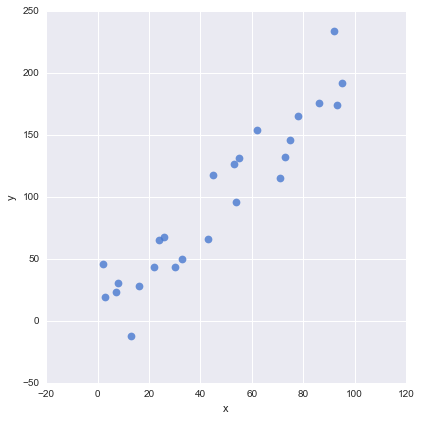

In [10]:
a, b, c, e = 5, 2, 0, 15 
df = generate_data(a=5, b=2, latent_error_y=25)

y = lambda x: a + b*x + c*x**2
x = np.linspace(0, 100)

g = sns.lmplot(x='x', y='y', data=df, fit_reg=False  
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

## NOTE: `lmplot()` will fit and plot a lin. reg. line by default. 
## Not used here, but can greatly help data exploration in practice.

### Fitting an Ordinary Least Square Regression

In [11]:
import patsy as pt  
import statsmodels.api as sm

## first, encode model specification as design matrices
fml = 'y ~ 1 + x'  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe'
                              ,NA_action='raise')

## fit OLS model and print results
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     187.1
Date:                Tue, 19 Apr 2016   Prob (F-statistic):           1.56e-12
Time:                        02:12:37   Log-Likelihood:                -111.53
No. Observations:                  25   AIC:                             227.1
Df Residuals:                      23   BIC:                             229.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.2536      8.024      0.655      0.5

### Vizualizing

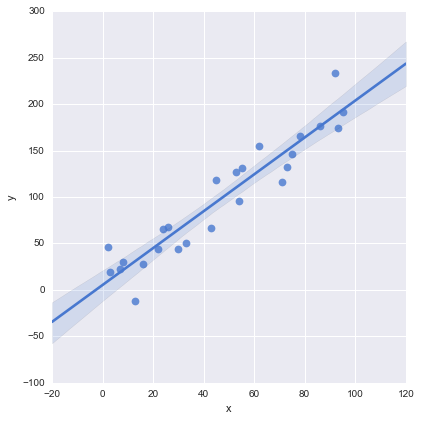

In [12]:
sns.lmplot(x='x', y='y', data=df, fit_reg=True,size=6, scatter_kws={'alpha':0.8, 's':60})

# Generalized Linear Model using PyMC

The Maximum A Posteriori (MAP) was found using Powell Optimization which is basically 
>*An efficient method for finding the minimum of a function of several variables without calculating derivatives*

Uses NUTS (No U Turn Sampling) for sampling 
>*a self-tuning variant of Hamiltonian Monte Carlo*

In [13]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.Normal())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.5 sec

### Vizualizing

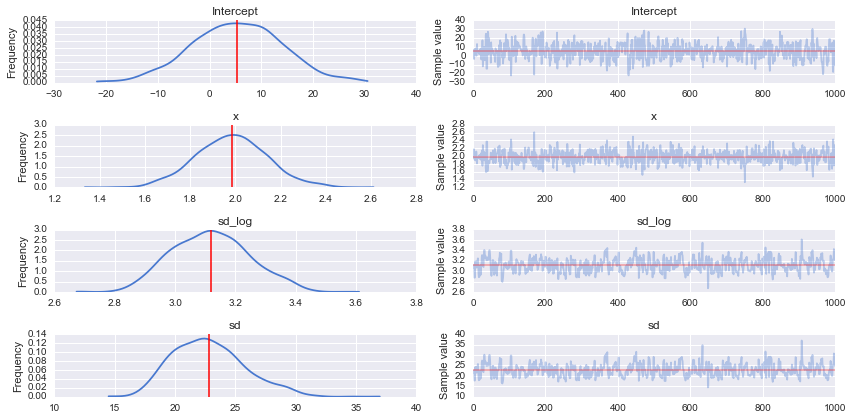

In [14]:
pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()});

### Summary

In [15]:
pm.df_summary(trc_ols[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,5.344235,8.820458,0.365775,-12.399915,22.249511
x,1.983668,0.157843,0.006285,1.667631,2.288837
sd_log,3.119262,0.129190,0.007414,2.889595,3.375752
sd,22.820487,2.986939,0.172024,17.766441,28.984245


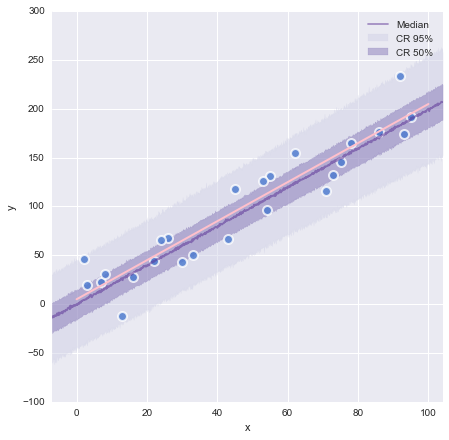

In [17]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims);
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2);

# Student T-distribution

In [18]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.StudentT())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

Applied log-transform to lam and added transformed lam_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.4 sec

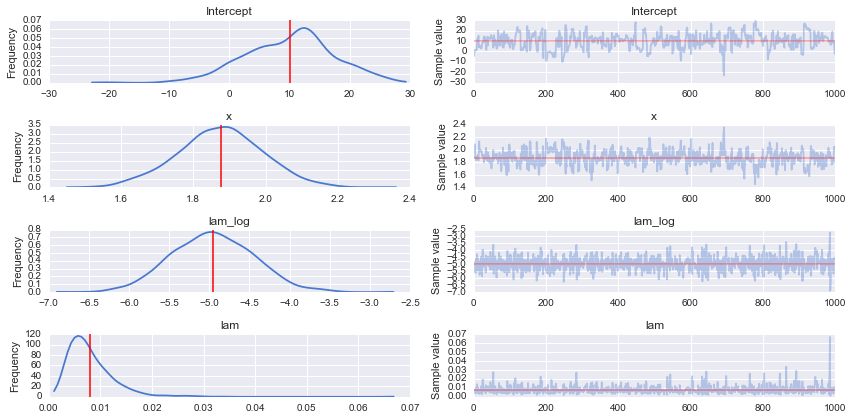

In [19]:
pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()});

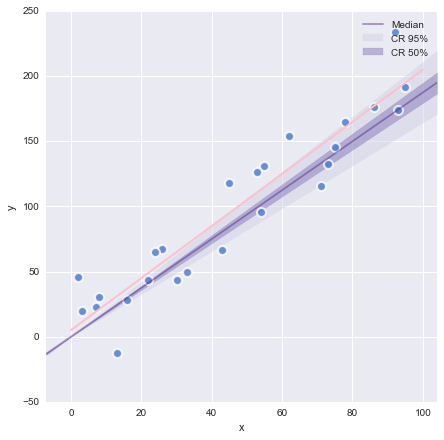

In [21]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['lam']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2);

# Bayesian Linear Regression

In [22]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


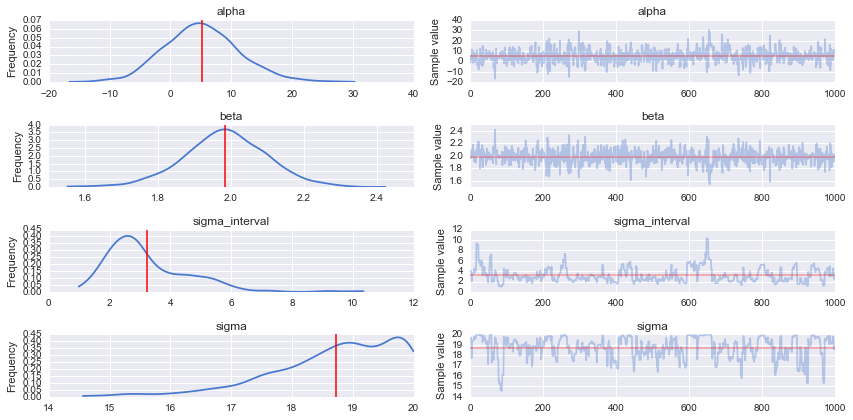

In [23]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()});

In [24]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,5.215657,6.365844,0.269555,-6.789418,18.021014
beta,1.983683,0.116324,0.004689,1.741227,2.200559
sigma_interval,3.234367,1.405458,0.115179,1.184618,5.758135
sigma,18.726145,1.052913,0.080377,16.710189,19.999323


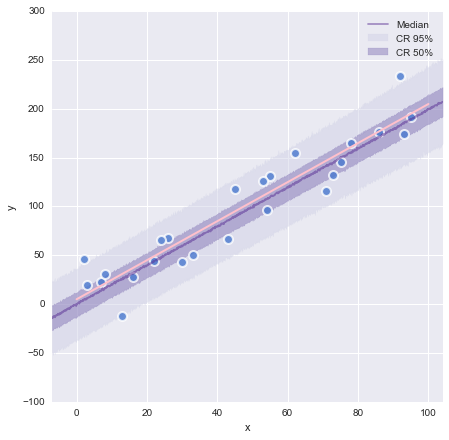

In [26]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['alpha','beta']]
    trc_sd = pm.trace_to_dataframe(trc)['sigma']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(model, trace, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2);

# Bayesian Quadratic Regression

In [27]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    mewmew = pm.Normal('mewmew', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x'] + mewmew * df['x'] * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


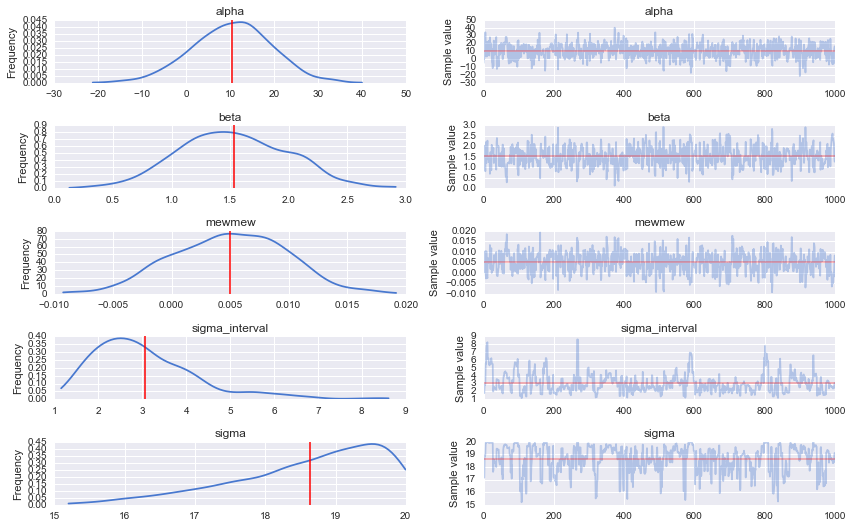

In [28]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()});

In [29]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,10.410899,9.081642,0.375544,-8.432058,26.609146
beta,1.532853,0.467338,0.021129,0.619654,2.406558
mewmew,0.004964,0.004823,0.000216,-0.004791,0.013427
sigma_interval,3.063913,1.235966,0.093666,1.225086,5.630940
sigma,18.632866,1.055542,0.070893,16.520678,19.996347


In [30]:
import matplotlib.pyplot as plt
import numpy as np 
def graph(formula, x_range, color='black', alpha=1):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y, color=color, alpha=alpha)

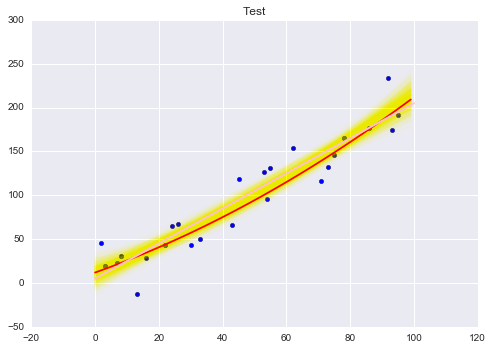

In [31]:
plt.scatter(df['x'],df['y'])

for i in range(0,2000):
    point = trace.point(i)
    graph('{0} + {1}*x + {2}*x*x'.format(point['alpha'], point['beta'], point['mewmew']), range(0,100), color='yellow', alpha=.00908035)

graph('11.9 + 1.3*x + .007*x*x', range(0,100), color='red', alpha=1)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)
plt.title('Test')
plt.show()


# Missing Value Imputation

In [33]:
test_scores = pd.read_csv('test_scores.csv').fillna(-999)
qgrid.show_grid(test_scores)

In [34]:
trc = None
from pymc3 import *
import numpy as np
import pandas as pd
from numpy.ma import masked_values

# Import data, filling missing values with sentinels (-999)
test_scores = pd.read_csv('test_scores.csv').fillna(-999)

# Extract variables: test score, gender, number of siblings, previous disability, age, 
# mother with HS education or better, hearing loss identified by 3 months of age
(score, male, siblings, disability, 
    age, mother_hs, early_ident) = test_scores[['score', 'male', 'siblings', 
                                                'prev_disab', 'age_test',
                                                'mother_hs', 'early_ident']].astype(float).values.T

with Model() as model:

    # Impute missing values
    sib_mean = Exponential('sib_mean', 1)
    siblings_imp = Poisson('siblings_imp', sib_mean, observed=masked_values(siblings, value=-999))

    p_disab = Beta('p_disab', 1, 1)
    disability_imp = Bernoulli('disability_imp', p_disab, observed=masked_values(disability, value=-999))

    p_mother = Beta('p_mother', 1, 1)
    mother_imp = Bernoulli('mother_imp', p_mother, observed=masked_values(mother_hs, value=-999))

    s = HalfCauchy('s', 5, testval=5)
    beta = Laplace('beta', 0, 100, shape=7, testval=.1)

    expected_score = (beta[0] + beta[1]*male + beta[2]*siblings_imp + beta[3]*disability_imp + 
        beta[4]*age + beta[5]*mother_imp + beta[6]*early_ident)

    observed_score = Normal('observed_score', expected_score, s ** -2, observed=score)


with model:
    start = find_MAP()
    step1 = NUTS([beta, s, p_disab, p_mother, sib_mean], scaling=start)

    step2 = Metropolis([mother_imp.missing_values, 
                        disability_imp.missing_values,
                        siblings_imp.missing_values])

def run(n=5000):
    if n == 'short':
        n = 100
    with model:
        global trc
        trc = sample(n, [step1, step2], start)

if __name__ == '__main__':
    run()
    

Applied log-transform to sib_mean and added transformed sib_mean_log to model.
Applied logodds-transform to p_disab and added transformed p_disab_logodds to model.
Applied logodds-transform to p_mother and added transformed p_mother_logodds to model.
Applied log-transform to s and added transformed s_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 35.1 sec

In [37]:
pm.summary(trc)


sib_mean_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.115            0.068            0.001            [-0.019, 0.246]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.022         0.070          0.117          0.160          0.245


siblings_imp_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|


p_disab_logodds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -1.273           0.168            0.002            [-1.615, -